In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plot_start_date = '2008-07-01'

# Load the data (replace with your file paths)
data = pd.read_csv('PriceStats_CPI.csv')


# Use the first CPI value of each month as that month's CPI
data['date'] = pd.to_datetime(data['date'])

data = data.groupby(pd.Grouper(key='date', freq='MS'))
dataOg = data.mean()
data = data.first()

# Work in log scale
data['CPI'] = np.log(data['CPI'])
data['PriceStats'] = np.log(data['PriceStats'])

# rename columnsq
data = data.rename(columns={'CPI': 'CPI_first', 'PriceStats': 'PriceStats_first'})

dataOg['CPI'] = np.log(dataOg['CPI'])
dataOg['PriceStats'] = np.log(dataOg['PriceStats'])

# rename columnsq
dataOg = dataOg.rename(columns={'CPI': 'CPI_avg', 'PriceStats': 'PriceStats_avg'})


# merge dataframes
data = data.merge(dataOg, how='left', left_index=True, right_index=True)


# cpi_df.interpolate(inplace=True)

# Drop any rows with NaN values
data = data.dropna()

# t5yie_df['date'] = pd.to_datetime(t5yie_df['DATE'])
# t5yie_df = t5yie_df.set_index('date')
# t5yie_df = t5yie_df.resample('M').first()

# t10yie_df['date'] = pd.to_datetime(t10yie_df['DATE'])
# t10yie_df = t10yie_df.set_index('date')
# t10yie_df = t10yie_df.resample('M').first()


# Train-test split
train_data_cpi = data.loc[data.index < '2013-09-01', 'CPI_first']
test_data_cpi = data.loc[data.index >= '2013-09-01', 'CPI_first']

data.head()
cpi_data = data['CPI_first']

# interpolate missing values


# make sure it is all numbe



In [3]:
data

,PriceStats_first,CPI_first,PriceStats_avg,CPI_avg
date,,,,
2008-07-01,4.605170,4.605170,4.604380,4.605170
2008-08-01,4.603745,4.610407,4.602438,4.610407
2008-09-01,4.601708,4.606407,4.602873,4.606407
2008-10-01,4.602409,4.605024,4.595234,4.605024
2008-11-01,4.584871,4.594871,4.576994,4.594871
...,...,...,...,...
2018-05-01,4.748351,4.740586,4.750045,4.740586
2018-06-01,4.752133,4.744736,4.752183,4.744736
2018-07-01,4.752463,4.746329,4.753506,4.746329


New best order: 1 (MSE: 8.237064689436477e-06)
New best order: 2 (MSE: 6.3508968048341465e-06)
New best order: 3 (MSE: 5.69317882331669e-06)
New best order: 4 (MSE: 5.661315855981922e-06)
Best order: 4


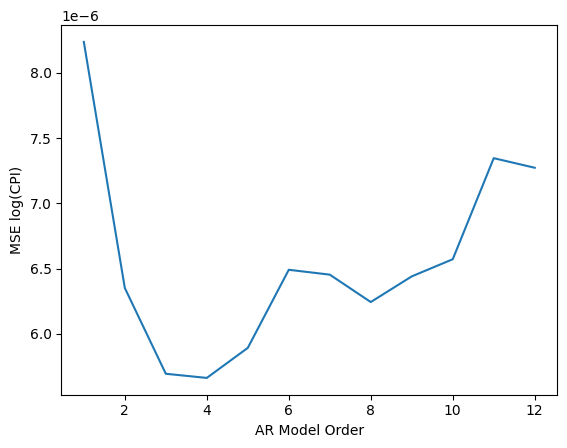

In [4]:
best_order = 0
min_mse = float('inf')
mse_list = []
preds = []
best_model = None
for order in range(1, 13):  # Test AR models of orders 1-12
    model = AutoReg(train_data_cpi, lags=order)
    model_fit = model.fit()
    pred = AutoReg(data['CPI_first'], lags=order, old_names=False)
    
    predictions = pred.predict(model_fit.params, start=len(train_data_cpi), end=len(data)-1)

    mse = mean_squared_error(test_data_cpi, predictions)
    mse_list.append(mse)
    if mse < min_mse:
        min_mse = mse
        best_order = order

        best_model = model_fit
        preds = predictions
        print(f"New best order: {order} (MSE: {mse})")

print(f"Best order: {best_order}")
plt.xlabel('AR Model Order')
plt.ylabel('MSE log(CPI)')
plt.plot(range(1, 13), mse_list)
plt.show()


In [5]:
# Load BER data
ber_5yr = pd.read_csv('T5YIE.csv')
ber_10yr = pd.read_csv('T10YIE.csv')

ber_5yr['T5YIE'] = pd.to_numeric(ber_5yr['T5YIE'], errors='coerce')
ber_10yr['T10YIE'] = pd.to_numeric(ber_10yr['T10YIE'], errors='coerce')

# Convert the date columns to datetime objects
ber_5yr['DATE'] = pd.to_datetime(ber_5yr['DATE'])
ber_10yr['DATE'] = pd.to_datetime(ber_10yr['DATE'])

# Set the index to the date column
ber_5yr.set_index('DATE', inplace=True)
ber_10yr.set_index('DATE', inplace=True)

# Calculate monthly inflation rates from BER data
# ber_5yr['monthly_inflation'] = ber_5yr['T5YIE']/100)**(1/12) - 1) * 100
# ber_10yr['monthly_inflation'] = ((1 + ber_10yr['T10YIE']/100)**(1/12) - 1) * 100

ber_5yr['monthly_inflation'] = ber_5yr['T5YIE']
ber_10yr['monthly_inflation'] = ber_10yr['T10YIE']


In [6]:
ber_5yr_first = ber_5yr.groupby(pd.Grouper(freq='MS')).first()
ber_10yr_first = ber_10yr.groupby(pd.Grouper(freq='MS')).first()


# Make sure the BER data is in the same date range as the CPI data
ber_5yr_first = ber_5yr_first.loc[ber_5yr_first.index >= plot_start_date]
ber_10yr_first = ber_10yr_first.loc[ber_10yr_first.index >= plot_start_date]

# Make sure the BER data is same length
ber_5yr_first = ber_5yr_first.loc[ber_5yr_first.index <= '2018-09-01']
ber_10yr_first = ber_10yr_first.loc[ber_10yr_first.index <= '2018-09-01']

# rename columns
ber_5yr_first = ber_5yr_first.rename(columns={'monthly_inflation': 'ber_5yr_first'})
ber_10yr_first = ber_10yr_first.rename(columns={'monthly_inflation': 'ber_10yr_fisrt'})

In [7]:
ber_5yr_first

,T5YIE,ber_5yr_first
DATE,,
2008-07-01,2.66,2.66
2008-08-01,2.17,2.17
2008-09-01,1.72,1.72
2008-10-01,0.95,0.95
2008-11-01,-0.95,-0.95
...,...,...
2018-05-01,2.09,2.09
2018-06-01,2.06,2.06
2018-07-01,2.07,2.07


In [8]:
ber_5yr_monthly_avg = ber_5yr.groupby(pd.Grouper(freq='MS')).mean()
ber_10yr_monthly_avg = ber_10yr.groupby(pd.Grouper(freq='MS')).mean()
# rename the column
ber_5yr_monthly_avg = ber_5yr_monthly_avg.rename(columns={'monthly_inflation': '5yr_avg_monthly_inflation'})
ber_10yr_monthly_avg = ber_10yr_monthly_avg.rename(columns={'monthly_inflation': '10yr_avg_monthly_inflation'})


In [9]:
# merge the data
merged = pd.merge(data, ber_5yr_first, left_index=True, right_index=True)
merged = pd.merge(merged, ber_10yr_first, left_index=True, right_index=True)
merged = pd.merge(merged, ber_5yr_monthly_avg, left_index=True, right_index=True)
merged = pd.merge(merged, ber_10yr_monthly_avg, left_index=True, right_index=True)
merged.head()

#drop nan
merged = merged.dropna()
merged



,PriceStats_first,CPI_first,PriceStats_avg,CPI_avg,T5YIE_x,ber_5yr_first,T10YIE_x,ber_10yr_fisrt,T5YIE_y,5yr_avg_monthly_inflation,T10YIE_y,10yr_avg_monthly_inflation
2008-07-01,4.605170,4.605170,4.604380,4.605170,2.66,2.66,2.52,2.52,2.462727,2.462727,2.438636,2.438636
2008-08-01,4.603745,4.610407,4.602438,4.610407,2.17,2.17,2.34,2.34,1.993810,1.993810,2.209524,2.209524
2008-09-01,4.601708,4.606407,4.602873,4.606407,1.72,1.72,2.05,2.05,1.330952,1.330952,1.836190,1.836190
2008-10-01,4.602409,4.605024,4.595234,4.605024,0.95,0.95,1.51,1.51,-0.027727,-0.027727,1.061818,1.061818
2008-11-01,4.584871,4.594871,4.576994,4.594871,-0.95,-0.95,0.87,0.87,-1.398889,-1.398889,0.638333,0.638333
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-01,4.748351,4.740586,4.750045,4.740586,2.09,2.09,2.16,2.16,2.101818,2.101818,2.141818,2.141818
2018-06-01,4.752133,4.744736,4.752183,4.744736,2.06,2.06,2.09,2.09,2.067619,2.067619,2.117619,2.117619
2018-07-01,4.752463,4.746329,4.753506,4.746329,2.07,2.07,2.14,2.14,2.042381,2.042381,2.114286,2.114286
2018-08-01,4.754427,4.746396,4.754611,4.746396,2.00,2.00,2.13,2.13,1.982609,1.982609,2.099130,2.099130


In [10]:
# get training and testing data from merge
train_data = merged.loc[merged.index < '2013-09-01']
test_data = merged.loc[merged.index >= '2013-09-01']

In [11]:
train_data.head()


,PriceStats_first,CPI_first,PriceStats_avg,CPI_avg,T5YIE_x,ber_5yr_first,T10YIE_x,ber_10yr_fisrt,T5YIE_y,5yr_avg_monthly_inflation,T10YIE_y,10yr_avg_monthly_inflation
2008-07-01,4.605170,4.605170,4.604380,4.605170,2.66,2.66,2.52,2.52,2.462727,2.462727,2.438636,2.438636
2008-08-01,4.603745,4.610407,4.602438,4.610407,2.17,2.17,2.34,2.34,1.993810,1.993810,2.209524,2.209524
2008-09-01,4.601708,4.606407,4.602873,4.606407,1.72,1.72,2.05,2.05,1.330952,1.330952,1.836190,1.836190
2008-10-01,4.602409,4.605024,4.595234,4.605024,0.95,0.95,1.51,1.51,-0.027727,-0.027727,1.061818,1.061818
2008-11-01,4.584871,4.594871,4.576994,4.594871,-0.95,-0.95,0.87,0.87,-1.398889,-1.398889,0.638333,0.638333


In [12]:
train_exog = train_data[["PriceStats_first", 'ber_5yr_first', 'ber_10yr_fisrt']]
train_exog_avg = train_data[["PriceStats_avg", '5yr_avg_monthly_inflation', '10yr_avg_monthly_inflation']]

In [13]:
test_exog = test_data[["PriceStats_first", 'ber_5yr_first', 'ber_10yr_fisrt']]
test_exog_avg = test_data[["PriceStats_avg", '5yr_avg_monthly_inflation', '10yr_avg_monthly_inflation']]


In [14]:
mergedFirst = merged[["PriceStats_first", 'ber_5yr_first', 'ber_10yr_fisrt']]
mergedAvg = merged[["PriceStats_avg", '5yr_avg_monthly_inflation', '10yr_avg_monthly_inflation']]
mergedFirst.head()

,PriceStats_first,ber_5yr_first,ber_10yr_fisrt
2008-07-01,4.605170,2.66,2.52
2008-08-01,4.603745,2.17,2.34
2008-09-01,4.601708,1.72,2.05
2008-10-01,4.602409,0.95,1.51
2008-11-01,4.584871,-0.95,0.87


In [15]:
best_order

4

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.19190D+00    |proj g|=  4.36769D+01

At iterate    5    f= -4.19785D+00    |proj g|=  2.20296D+00

At iterate   10    f= -4.19822D+00    |proj g|=  4.05245D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     11     53      2     0     0   4.052D-01  -4.198D+00
  F =  -4.1982151525306666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


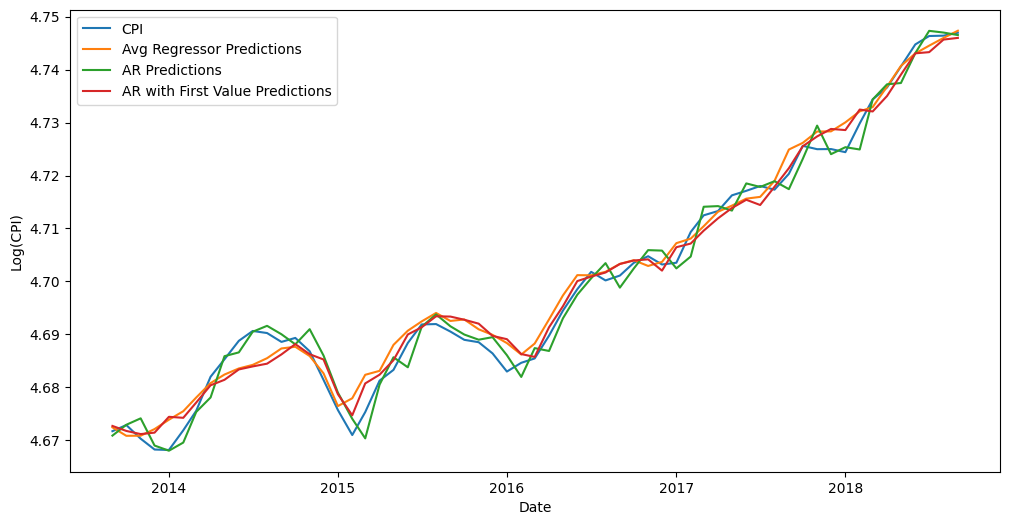

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plot_start_date = '2013-09-01'

# SARIMAX model with monthly average external regressors
model_avg = SARIMAX(train_data_cpi, exog=train_exog_avg, order=(best_order, 0, 0))
model_avg_fit = model_avg.fit()

predictions_avg = model_avg_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_exog_avg)

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'CPI_first'], label='CPI')
plt.plot(predictions_avg, label='Avg Regressor Predictions')
plt.legend()

model_first = SARIMAX(train_data_cpi, exog=train_exog, order=(best_order, 0, 0))
model_first_fit = model_first.fit()

predictions_first = model_avg_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_exog)
print("hi")

# plot the results
plt.plot(preds.index, preds, label='AR Predictions')
plt.plot(predictions_avg.index, predictions_first, label='AR with First Value Predictions')
plt.xlabel('Date')
plt.ylabel('Log(CPI)')

plt.legend()


In [17]:
# get mse of each model
mse_avg = mean_squared_error(test_data_cpi, predictions_avg)
mse_first = mean_squared_error(test_data_cpi, predictions_first)

print('MSE of AR Model with Average Regressors: ', mse_avg)
print('MSE of AR Model with First Value Regressors: ', mse_first)

# print best model
if mse_avg < mse_first:
    print('AR Model with Average Regressors is better')
else :
    print('AR Model with First Value Regressors is better')

MSE of AR Model with Average Regressors:  8.967563365474245e-06
MSE of AR Model with First Value Regressors:  7.946644575709876e-06
AR Model with First Value Regressors is better


In [18]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Find the best combination of parameters
p = q = range(0, 2)
d = range(0, 1)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

min_aic = float('inf')
best_params = (0, 0, 0)
best_seasonal_params = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        print("ASDASDASDASDASDDASASDASDASDADSASDASDDASa")
        try:
            model = SARIMAX(train_data_cpi, order=param, seasonal_order=param_seasonal, exog=train_exog.iloc[:, 1:], enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print(f"ARIMA{param}x{param_seasonal} - AIC: {results.aic}")
            if results.aic < min_aic:
                min_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f"Best ARIMA parameters: {best_params}, best seasonal parameters: {best_seasonal_params}")

# Fit the best SARIMAX model
# best_model = SARIMAX(train_data_cpi, order=best_params, seasonal_order=best_seasonal_params, exog=train_exog.iloc[:, 1:], enforce_stationarity=False, enforce_invertibility=False)
# best_results = best_model.fit()
# pred_improved = best_results.get_prediction(start=pd.to_datetime('2013-09-01'), end=pd.to_datetime('2023-04-01'), exog=test_ext.iloc[:, 1:], dynamic=True)
# mse_improved = mean_squared_error(test_ext.iloc[:, 0], pred_improved.predicted_mean)

# print(f"Mean squared error with improved SARIMAX model: {mse_improved}")


ASDASDASDASDASDDASASDASDASDADSASDASDDASa
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65800D+00    |proj g|=  1.64132D-01

At iterate    5    f=  1.11113D+00    |proj g|=  6.57948D-03

At iterate   10    f=  1.11070D+00    |proj g|=  5.33195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 143.72577790183394
ASDASDASDASDASDDASASDASDASDADSASDASDDASa
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   4.452D-06   1.111D+00
  F =   1.1106917572728543 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.15950D-01    |proj g|=  4.87134D-02

At iterate   15    f=  2.96797D-01    |proj g|=  9.15108D-02

At iterate   20    f=  2.88674D-01    |proj g|=  4.74087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   5.356D-06   2.887D-01
  F =  0.28867376355637692     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC: 47.79554668099074
ASDASDASDASDASDDASASDASDASDADSASDASDDASa
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.45568D-01    |proj g|=  1.52577D-01

At iterate   10    f=  3.28548D-01    |proj g|=  1.48864D-01

At iterate   15    f=  1.68026D-02    |proj g|=  1.41020D+00

At iterate   20    f= -1.99563D+00    |proj g|=  6.64752D+01

At iterate   25    f= -2.71031D+00    |proj g|=  5.32430D+02

At iterate   30    f= -3.26064D+00    |proj g|=  7.71725D+02

At iterate   35    f= -3.49357D+00    |proj g|=  6.02884D+00
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC: -423.20337672477217
ASDASDASDASDASDDASASDASDASDADSASDASDDASa

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    105      1     0     0   2.738D+0

 This problem is unconstrained.
/Users/merlimar/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/merlimar/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   40    f= -3.17406D+00    |proj g|=  8.94641D+02

At iterate   45    f= -3.47874D+00    |proj g|=  1.58868D+00

At iterate   50    f= -3.48328D+00    |proj g|=  2.66390D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     93      1     0     0   2.664D+01  -3.483D+00
  F =  -3.4832782501743975     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC: -419.9265030216253
ASDASDASDASDASDDASASDASDASDADSASDASDDASa
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables 

/Users/merlimar/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/merlimar/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f= -1.01543D+00    |proj g|=  5.10169D+01

At iterate   35    f= -1.57526D+00    |proj g|=  1.57576D+02

At iterate   40    f= -2.56980D+00    |proj g|=  8.15537D+02

At iterate   45    f= -3.04004D+00    |proj g|=  1.73271D+02

At iterate   50    f= -3.04972D+00    |proj g|=  2.21162D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    104      1     0     0   2.212D+01  -3.050D+00
  F =  -3.0497209679560817     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC: -364.16540002655415
Best ARIMA parameters: (1, 0, 0), best seasonal parameter

/Users/merlimar/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
test_data_cpi

date
2013-09-01    4.671739
2013-10-01    4.672902
2013-11-01    4.670323
2013-12-01    4.668278
2014-01-01    4.668193
                ...   
2018-05-01    4.740586
2018-06-01    4.744736
2018-07-01    4.746329
2018-08-01    4.746396
2018-09-01    4.746952
Freq: MS, Name: CPI_first, Length: 61, dtype: float64

In [23]:
# Fit the best SARIMAX model
best_model = SARIMAX(train_data_cpi, order=best_params, seasonal_order=best_seasonal_params, exog=train_exog.iloc[:, 1:], enforce_stationarity=False, enforce_invertibility=False)
best_results = best_model.fit()
pred_improved = best_results.get_prediction(start=pd.to_datetime('2013-09-01'), end=pd.to_datetime('2018-08-11'), exog=test_exog.iloc[:, 1:], dynamic=True)
mse_improved = mean_squared_error(test_data_cpi, pred_improved.predicted_mean)

print(f"Mean squared error with improved SARIMAX model: {mse_improved}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04325D+00    |proj g|=  1.27699D-01

At iterate    5    f=  7.57409D-01    |proj g|=  3.57555D-01

At iterate   10    f=  1.85014D-01    |proj g|=  1.93737D+00

At iterate   15    f= -6.36289D-01    |proj g|=  9.36796D+01

At iterate   20    f= -1.86914D+00    |proj g|=  4.48474D+01

At iterate   25    f= -3.40639D+00    |proj g|=  2.43181D+02

At iterate   30    f= -3.95092D+00    |proj g|=  7.89008D+01

At iterate   35    f= -3.97797D+00    |proj g|=  1.06475D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


MSE of AR Model with Average Regressors:  8.967563365474245e-06
MSE of AR Model with First Value Regressors:  7.946644575709876e-06
MSE of Improved SARIMAX Model:  5.176469076465363e-05


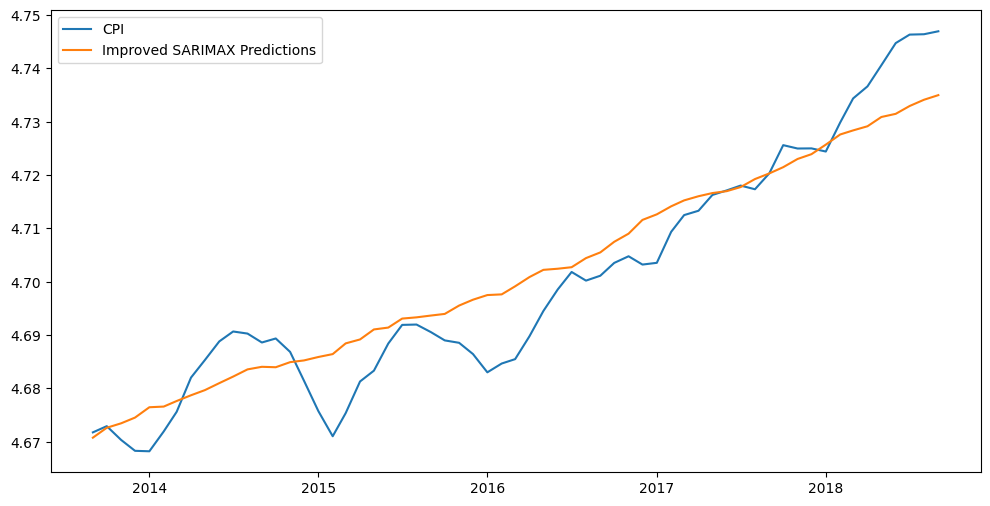

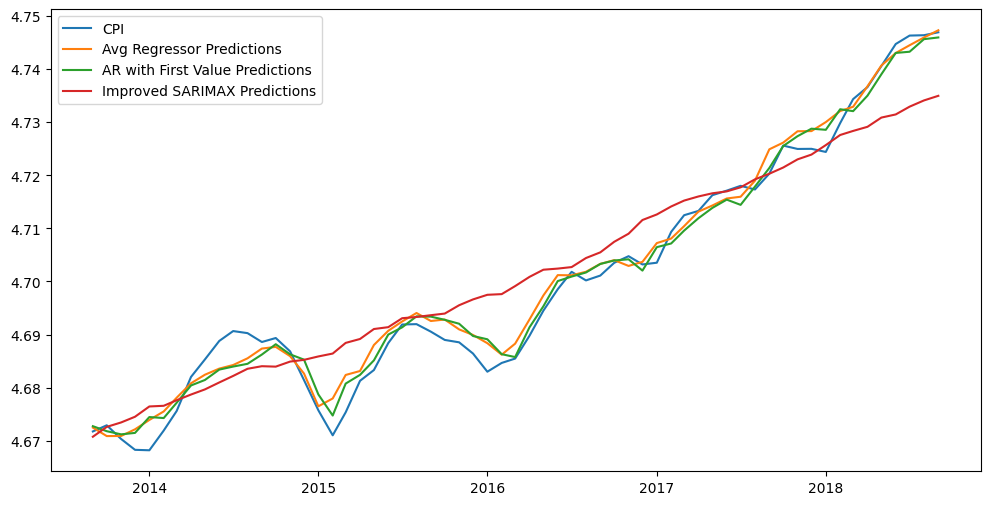

In [29]:
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'CPI_first'], label='CPI')
plt.plot(pred_improved.predicted_mean, label='Improved SARIMAX Predictions')
plt.legend()

# print mse of each model
mse_avg = mean_squared_error(test_data_cpi, predictions_avg)
mse_first = mean_squared_error(test_data_cpi, predictions_first)
mse_improved = mean_squared_error(test_data_cpi, pred_improved.predicted_mean)

print('MSE of AR Model with Average Regressors: ', mse_avg)
print('MSE of AR Model with First Value Regressors: ', mse_first)
print('MSE of Improved SARIMAX Model: ', mse_improved)

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.loc[data.index >= plot_start_date].index, data.loc[data.index >= plot_start_date, 'CPI_first'], label='CPI')
plt.plot(predictions_avg, label='Avg Regressor Predictions')
plt.plot(predictions_first, label='AR with First Value Predictions')
plt.plot(pred_improved.predicted_mean, label='Improved SARIMAX Predictions')
plt.legend()
